In [1]:
import pandas as pd
import numpy as np
import pandasql as psql
import sqlite3

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))
pd.options.display.float_format = '{:,.4f}'.format

# Load the data

In [2]:
db = sqlite3.connect('viabill.db')
customers = pd.read_sql_query("SELECT * FROM customers", db)
transactions = pd.read_sql_query("SELECT * FROM transactions", db)

In [3]:
def describe_plus(data):
    
    """
    Extended version of the basic describe function.
    """
    
    describe = data.describe(include='all').T
    unique = []
    missing = []
    
    for c in list(describe.index):
        
        unique.append(data[c].nunique())
        missing.append(data[c].isna().sum())
        
    describe['unique'] = unique
    describe['missing'] = missing
    describe['count'] = describe['count'].astype(int)
    
    return describe[['count','unique','missing']+list(describe.columns[4:11])]

Descriptive statistics of customer-related variables

In [4]:
describe_plus(customers)

,count,unique,missing,mean,std,min,25%,50%,75%,max
customerID,500000,500000,0,"250,000.5000","144,337.7116",1.0000,"125,000.7500","250,000.5000","375,000.2500","500,000.0000"
sex,500000,3,0,1.1504,0.4778,0.0000,1.0000,1.0000,1.0000,2.0000
age,500000,85,0,44.6305,16.1783,5.0000,27.0000,50.0000,58.0000,90.0000
residentialAddress,500000,396022,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
postalAddress,500000,389469,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
income,490025,1001,9975,"50,000.0392","28,899.1197",0.0000,"25,000.0000","50,000.0000","75,000.0000","100,000.0000"


Filter out those customers who are under 18 years old based on the Terms and Conditions at ViaBill

In [5]:
customers = customers.loc[customers['age'] >= 18].copy()

Descriptive statistics of transaction-related variables

In [6]:
describe_plus(transactions)

,count,unique,missing,mean,std,min,25%,50%,75%,max
transactionID,2000000,2000000,0,"1,000,000.5000","577,350.4135",1.0000,"500,000.7500","1,000,000.5000","1,500,000.2500","2,000,000.0000"
shopID,2000000,900,0,549.2549,259.8474,100.0000,324.0000,549.0000,774.0000,999.0000
customerID,2000000,490534,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,2000000,198,0,101.5293,57.1758,3.0000,52.0000,102.0000,151.0000,200.0000
paytmentStatus1,2000000,3,0,0.1176,0.3607,0.0000,0.0000,0.0000,0.0000,2.0000
paytmentStatus2,2000000,3,0,0.1474,0.4279,0.0000,0.0000,0.0000,0.0000,2.0000
paytmentStatus3,2000000,3,0,0.1896,0.5054,0.0000,0.0000,0.0000,0.0000,2.0000
paytmentStatus4,2000000,3,0,0.2686,0.6169,0.0000,0.0000,0.0000,0.0000,2.0000


Detect and filter out those transactions whose Customer ID are missing

In [7]:
transactions['customerID'].value_counts()[0:5]

          20017
61875        16
270525       16
47943        15
110021       15
Name: customerID, dtype: int64

In [8]:
transactions = transactions.loc[transactions['customerID'] != transactions['customerID'].value_counts().index[0]].copy()
transactions['customerID'] = transactions['customerID'].astype(int)

# Create application data with features

Last transaction of each customer was selected with trans_index = 1 condition at the end. That was the last step of the whole select, because it was easier to create features from historical transactions this way instead of left joins later.

In [9]:
start = timer()

applications = psql.sqldf("""

with base as (

select tr3.*,
cu1.sex, cu1.age, cu1.residentialAddress, cu1.postalAddress,
coalesce(cu1.income,-999) as income from
(
    select tr2.*,
    
    AVG(price) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as trans_price_avg_lst3,
    MIN(price) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as trans_price_min_lst3,
    MAX(price) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as trans_price_max_lst3,
    COUNT(1) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as trans_index_lst3,
    
    AVG(paid_1_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as paid_1_avg_lst3,
    AVG(paid_2_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as paid_2_avg_lst3,
    AVG(paid_3_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as paid_3_avg_lst3,
    AVG(paid_4_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as paid_4_avg_lst3,
    
    AVG(late_1_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as late_1_avg_lst3,
    AVG(late_2_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as late_2_avg_lst3,
    AVG(late_3_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as late_3_avg_lst3,
    AVG(late_4_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as late_4_avg_lst3,
    
    AVG(default_1_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as default_1_avg_lst3,
    AVG(default_2_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as default_2_avg_lst3,
    AVG(default_3_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as default_3_avg_lst3,
    AVG(default_4_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as default_4_avg_lst3,
    
    MAX(defaulted_fl) OVER(PARTITION BY customerID ORDER BY trans_index range between 1 following and 3 following) as defaulted_lst3
    
    from
    
    (
        select tr1.*, 
        ROW_NUMBER() OVER(PARTITION BY customerID ORDER BY transactionID DESC) as trans_index,
        
        CASE WHEN paytmentStatus1 = 0 then 1 else 0 end as paid_1_fl,
        CASE WHEN paytmentStatus2 = 0 then 1 else 0 end as paid_2_fl,
        CASE WHEN paytmentStatus3 = 0 then 1 else 0 end as paid_3_fl,
        CASE WHEN paytmentStatus4 = 0 then 1 else 0 end as paid_4_fl,
        
        CASE WHEN paytmentStatus1 = 1 then 1 else 0 end as late_1_fl,
        CASE WHEN paytmentStatus2 = 1 then 1 else 0 end as late_2_fl,
        CASE WHEN paytmentStatus3 = 1 then 1 else 0 end as late_3_fl,
        CASE WHEN paytmentStatus4 = 1 then 1 else 0 end as late_4_fl,
        
        CASE WHEN paytmentStatus1 = 2 then 1 else 0 end as default_1_fl,
        CASE WHEN paytmentStatus2 = 2 then 1 else 0 end as default_2_fl,
        CASE WHEN paytmentStatus3 = 2 then 1 else 0 end as default_3_fl,
        CASE WHEN paytmentStatus4 = 2 then 1 else 0 end as default_4_fl,        
        
        CASE WHEN paytmentStatus1 = 2 or 
                  paytmentStatus2 = 2 or
                  paytmentStatus3 = 2 or
                  paytmentStatus4 = 2
        then 1 else 0 end as defaulted_fl

        from transactions tr1
        
    ) tr2
    
) tr3 inner join customers cu1

on tr3.customerID = cu1.customerID

)


select b1.*, s1.shops_nr_lst3

from base b1 left join
(

    select customerID, count(distinct shopID) as shops_nr_lst3 
    from base 
    where trans_index > 1 and trans_index <= 4
    group by customerID

) s1

on b1.customerID = s1.customerID

where b1.trans_index = 1

""")

end = timer()

print('Running time was '+str(round(((end - start)/60),1))+' min.')

Running time was 1.3 min.


# Dependency of Sex and Age

Visualize the distribution of variable Age

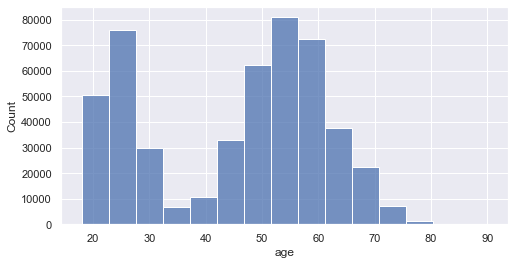

In [10]:
plt.figure(figsize=(8,4))
ax = sns.histplot(customers['age'], bins=15)
plt.show()

Visualize the distribution of variable Sex

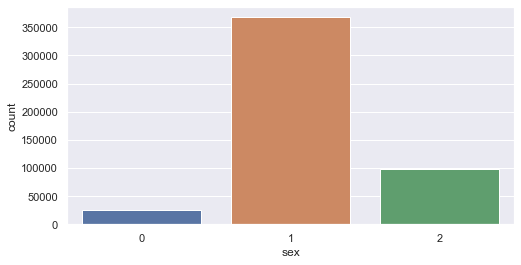

In [11]:
plt.figure(figsize=(8,4))
ax = sns.countplot(data=customers, x="sex", order=[0,1,2])
plt.show()

Categorize variable Age into equal-sized buckets to check statistical dependency with variable Sex.

In [12]:
customers['age_cat'] = pd.qcut(customers['age'], 10, labels=range(0,10)).astype(int)

Spearman correlation shows no dependence between Sex and categorized Age.

In [13]:
from scipy.stats import spearmanr
spearmanr(customers['sex'], customers['age_cat'])[0]

0.001798375085358017

Based on ANOVA test the null hypothesis (there is no difference in means) has to be rejected.

Sex and Age variables significantly independent from each other on the level of 95%.

In [14]:
from scipy.stats import f_oneway
f_oneway(customers['sex'], customers['age'])

F_onewayResult(statistic=3781397.612811474, pvalue=0.0)

# Find customer segments

Create features from residential address and postal address by taking the type of them

In [15]:
customers['residentialAddress'].value_counts(dropna=False).sort_index()[0:5]

1 Aaron Place          1
1 Abbeyfeale Street    1
1 Abbotsford Place     1
1 Abbott Street        2
1 Aberdeen Place       2
Name: residentialAddress, dtype: int64

In [16]:
customers['postalAddress'].value_counts(dropna=False).sort_index()[0:5]

                       9946
1 Aaron Place             1
1 Abbeyfeale Street       1
1 Abbotsford Place        1
1 Abbott Street           2
Name: postalAddress, dtype: int64

In [17]:
customers['res_address_type'] = customers['residentialAddress'].apply(lambda x: x.split()[-1].capitalize())
customers['post_address_type'] = np.where(customers['postalAddress']==customers['postalAddress'].value_counts().index[0], 'Missing', customers['postalAddress'])
customers['post_address_type'] = customers['post_address_type'].apply(lambda x: x.split()[-1].capitalize())

In [18]:
customers['res_address_type'].value_counts(normalize=True, dropna=False)[0:5]

Street   0.5859
Place    0.1023
Road     0.0932
Close    0.0467
Court    0.0453
Name: res_address_type, dtype: float64

In [19]:
customers['post_address_type'].value_counts(normalize=True, dropna=False)[0:5]

Street   0.5736
Place    0.1001
Road     0.0916
Close    0.0458
Court    0.0444
Name: post_address_type, dtype: float64

Create categories from address types

In [20]:
type_map = {'Street': 0, 'Place': 1, 'Road': 2, 'Missing': -1}

customers['res_address_type'] = customers['res_address_type'].map(type_map).fillna(3).astype(int)
customers['post_address_type'] = customers['post_address_type'].map(type_map).fillna(3).astype(int)

##### In order to reduce the running time a subsample has to be created

In [21]:
customers_subsample = train_test_split(customers, train_size=0.25, random_state=523)[0]

Create dummy variables from categorical variables

In [22]:
dummy_vars = ['sex', 'res_address_type', 'post_address_type']

customers_subsample = customers_subsample.join(pd.get_dummies(customers_subsample[dummy_vars], columns=dummy_vars)).copy()
customers_subsample['income'].fillna(-999, inplace=True)

Standardize features by removing the mean and scaling to unit variance

Using only customer-related features because not every customer has transactional history

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
sc_features = ['age', 'income'] + list(customers_subsample.columns[9:])
scaler.fit(customers_subsample[sc_features])

customers_subsample = customers_subsample.join(pd.DataFrame(scaler.transform(customers_subsample[sc_features]),
                                        index=customers_subsample.index, columns=['Scaled_'+f for f in sc_features]))

Choose the number of clusters in KMeans algorithm based on the Elbow Method

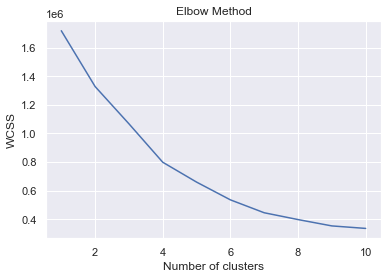

In [24]:
from sklearn.cluster import KMeans

wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(customers_subsample[['Scaled_'+f for f in sc_features]])
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1, 11), wcss)

plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')

plt.show()

The number of clusters parameter has selected as 4 based on the previous graph.

Measure the goodness of fit by Silhouette Score.

In [25]:
kmeans = KMeans(n_clusters=4, random_state=523)
kmeans.fit(customers_subsample[['Scaled_'+f for f in sc_features]])
customers_subsample['cluster'] = kmeans.predict(customers_subsample[['Scaled_'+f for f in sc_features]])

from sklearn.metrics import silhouette_score

silhouette_score(customers_subsample[['Scaled_'+f for f in sc_features]], customers_subsample['cluster'])

0.45786032066066584

In [26]:
customers_subsample[['customerID', 'cluster']].head()

,customerID,cluster
262182,262183,0
283547,283548,0
196827,196828,1
348159,348160,3
176614,176615,0


# Exploratory analysis and model fitting

Join previously created customer-related features to applications

In [27]:
applications = applications.merge(customers[['customerID']+customers.columns[7:].tolist()],
                   how='left', left_on='customerID', right_on='customerID').copy()

##### In order to reduce the running time a subsample has to be created

In [28]:
applications_subsample = train_test_split(applications, train_size=0.25, random_state=523, stratify=applications['defaulted_fl'])[0]

A stratified train-test splitting applied on the subsample

In [29]:
train_data, test_data = train_test_split(applications_subsample, test_size=0.3, 
                                         random_state=523, stratify=applications_subsample['defaulted_fl'])

### Feature engineering

#### Create grouped variables based on Weight of Evidence

The weight of evidence shows the predictive power of a variable in connection with the target variable.

In credit risk scorecard developing it is a measure of the separation of defaulted and non-defaulted clients.

In [30]:
features = list(train_data.columns[22:41])+['price']+list(train_data.columns[43:47])

Handle categorical features by decoding values with Weight of Evidence

In [31]:
features_cat = ['sex', 'res_address_type', 'post_address_type']

In [32]:
for df in [train_data, test_data]:
    
    df[features_cat] = df[features_cat].apply(lambda x: x.astype('str'))

In [33]:
%run -i py/01_decode_cat_vars.py

In [34]:
train_data.iloc[:,-3:].head()

,DEC_sex,DEC_res_address_type,DEC_post_address_type
306050,0.2097,0.0107,-0.0214
14342,0.2097,0.0194,0.0083
376751,0.2097,0.0194,0.0083
336002,0.2097,0.0205,0.0321
168474,-0.4683,0.0205,0.0321


In [35]:
test_data.iloc[:,-3:].head()

,DEC_sex,DEC_res_address_type,DEC_post_address_type
368441,0.2097,0.0205,0.0321
93880,0.2097,0.0194,0.0083
327481,-0.4683,0.0194,0.0083
216206,-0.4774,-0.0124,-0.0048
53453,0.2097,-0.0124,-0.0048


**Fine classing** is the following step from the process of Credit Risk Scorecard building.

Create equally-sized binned variables, if it is possible. Otherwise use the raw values (categories) as bins.

In this task 20 bins created for all of the variables.

In [36]:
%run -i py/02_fine_class.py

Keep only those variables where the Information Value is greater than 0.02

In [37]:
features_fine = list(x[4:] for x in fine_ivgini.loc[fine_ivgini['iv'] >= 0.02].sort_values(by='iv',ascending=False).reset_index(drop=True)['variable_name'])

In [38]:
fine_stats.head()

,orig_name,grp_name,grp,cnt,bad,good,min,max,pct_total,pct_bad,pct_good,target_rate,woe,iv
0,trans_price_avg_lst3,GRP_trans_price_avg_lst3,0,3952,326,3626,3.0000,35.0000,0.0469,0.0421,0.0473,0.0825,0.1186,0.0006
1,trans_price_avg_lst3,GRP_trans_price_avg_lst3,1,3849,310,3539,35.3333,49.6667,0.0456,0.0400,0.0462,0.0805,0.1446,0.0009
2,trans_price_avg_lst3,GRP_trans_price_avg_lst3,2,4114,372,3742,50.0000,60.0000,0.0488,0.0480,0.0489,0.0904,0.0181,0.0000
3,trans_price_avg_lst3,GRP_trans_price_avg_lst3,3,3897,375,3522,60.3333,68.0000,0.0462,0.0484,0.0460,0.0962,-0.0505,0.0001
4,trans_price_avg_lst3,GRP_trans_price_avg_lst3,4,3755,363,3392,68.3333,74.6667,0.0445,0.0468,0.0443,0.0967,-0.0556,0.0001


In [39]:
fine_ivgini.sort_values(by='iv', ascending=False).head()

,variable_name,iv,gini
0,GRP_default_4_avg_lst3,0.2226,0.1629
0,GRP_defaulted_lst3,0.1602,0.1504
0,GRP_default_3_avg_lst3,0.1536,0.1154
0,GRP_paid_4_avg_lst3,0.1209,0.1464
0,GRP_default_2_avg_lst3,0.1067,0.0783


**Coarse classing** is the next step from the process of Credit Risk Scorecard building.

Merge adjacent bins of the previously created grouped variables in the Fine classing step.

I wanted to merge and create 5 bins at maximum but it depended on the splitting algorithm. The goal is to choose the best *monotonous* merged version from all of the variables with the highest Information Value.

In [40]:
%run -i py/03_coarse_class.py

Keep only those variables where the Information Value is greater 0.02 and the merged groups are monotonous.

In [41]:
features_coarse = ['C3_default_4_avg_lst3', 'C2_defaulted_lst3', 'C2_default_3_avg_lst3',
                   'C4_paid_4_avg_lst3', 'C2_default_2_avg_lst3', 'C2_DEC_sex',
                   'C3_paid_3_avg_lst3', 'C3_paid_2_avg_lst3']

miss_dict = {}
for var in features_coarse:
    
    miss_dict[var] = -1

In [42]:
coarse_stats.head()

,orig_name,grp_name,grp,cnt,bad,good,min,max,pct_total,pct_bad,pct_good,target_rate,woe,iv
0,default_4_avg_lst3,C2_default_4_avg_lst3,0,72040,"5,735.0000","66,305.0000",0.0000,0.3333,0.8542,0.7398,0.8658,0.0796,0.1573,0.0198
1,default_4_avg_lst3,C2_default_4_avg_lst3,1,5878,"1,401.0000","4,477.0000",0.5000,1.0000,0.0697,0.1807,0.0585,0.2383,-1.1286,0.1380
2,default_4_avg_lst3,C2_default_4_avg_lst3,-1,6414,616.0000,"5,798.0000",NaN,NaN,0.0761,0.0795,0.0757,0.0960,-0.0484,0.0002
0,default_4_avg_lst3,C3_default_4_avg_lst3,0,62971,"4,593.0000","58,378.0000",0.0000,0.0000,0.7467,0.5925,0.7623,0.0729,0.2520,0.0428
1,default_4_avg_lst3,C3_default_4_avg_lst3,1,9069,"1,142.0000","7,927.0000",0.3333,0.3333,0.1075,0.1473,0.1035,0.1259,-0.3529,0.0155


In [43]:
coarse_ivgini.sort_values(by='iv', ascending=False).head()

,variable_name,iv,gini,monotonous_woe
0,C3_default_4_avg_lst3,0.1964,0.1604,1
0,C2_defaulted_lst3,0.1602,0.1504,1
0,C2_default_4_avg_lst3,0.1580,0.1095,1
0,C2_default_3_avg_lst3,0.1275,0.1120,1
0,C4_paid_4_avg_lst3,0.1183,0.1453,1


Create Weight of Evidence-decoded variables on the train sample and transfer them to the test sample

In [44]:
%run -i py/04_woe_transfer.py

### Feature selection

#### Correlation analysis of WoE-transformed variables

In [45]:
%run -i py/05_correlation.py

Correlation matrix with the variables in descending order based on Information Value

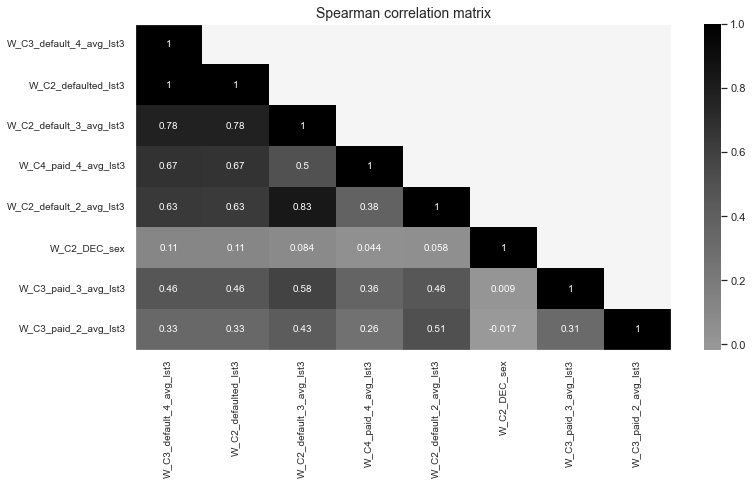

In [46]:
corr_plot(train_data, ['W_'+x for x in features_coarse], method='spearman')

Filter out those variables from highly correlated pairs (higher than 0.6) who have lower Information Value

In [47]:
features_woe_corr = filter_by_corr(train_data, ['W_'+x for x in features_coarse], 'spearman', threshold=0.6)

- Train sample

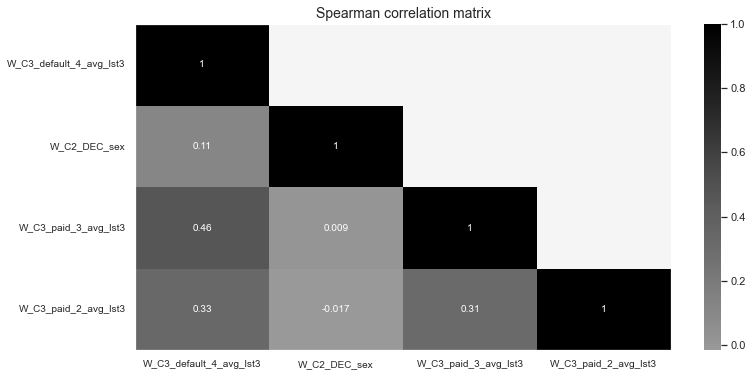

In [48]:
corr_plot(train_data, features_woe_corr, method='spearman')

- Test sample

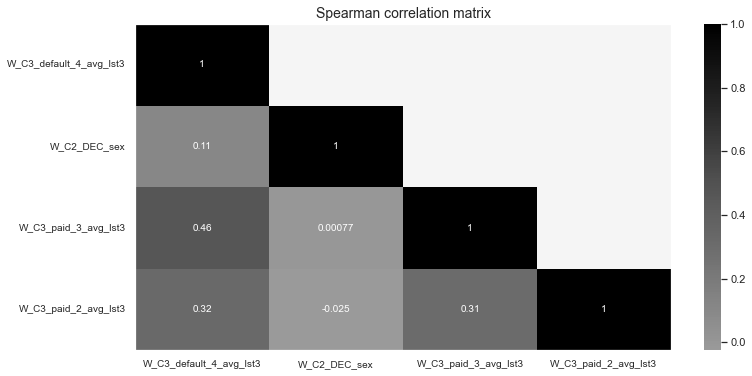

In [49]:
corr_plot(test_data, features_woe_corr, method='spearman')

#### Create dummy variables

In [50]:
train_data = train_data.join(pd.get_dummies(train_data[features_cat], drop_first=True))
test_data = test_data.join(pd.get_dummies(test_data[features_cat], drop_first=True))

#### Correlation analysis of continuous and dummy variables

Variable in descending order by their correlation with the target variable

In [51]:
features_dummy = list(train_data.columns[96:])
features_cont = list(train_data.columns[22:39])+['age','price']+list(train_data.columns[43:45])

Handle missing continous variables

In [52]:
train_data[features_cont] = train_data[features_cont].fillna(0)
test_data[features_cont] = test_data[features_cont].fillna(0)

In [53]:
pd.DataFrame(abs(train_data[['defaulted_fl']+features_dummy+features_cont].corr(method='pearson').iloc[1:,0]).sort_values(ascending=False)).rename(columns=({'defaulted_fl': 'CorrelationWithDefaultedFL'})).head(15)

,CorrelationWithDefaultedFL
default_4_avg_lst3,0.1585
default_3_avg_lst3,0.1313
defaulted_lst3,0.1256
default_2_avg_lst3,0.1090
sex_1,0.0956
paid_4_avg_lst3,0.0859
sex_2,0.0825
default_1_avg_lst3,0.0741
paid_3_avg_lst3,0.0583
paid_2_avg_lst3,0.0355


In [54]:
features_corr_sorted = abs(train_data[['defaulted_fl']+features_dummy+features_cont].corr(method='pearson').iloc[1:,0]).sort_values(ascending=False).index.tolist()

In [55]:
features_corr_filt = filter_by_corr(train_data, features_corr_sorted, 'pearson')

- Train sample

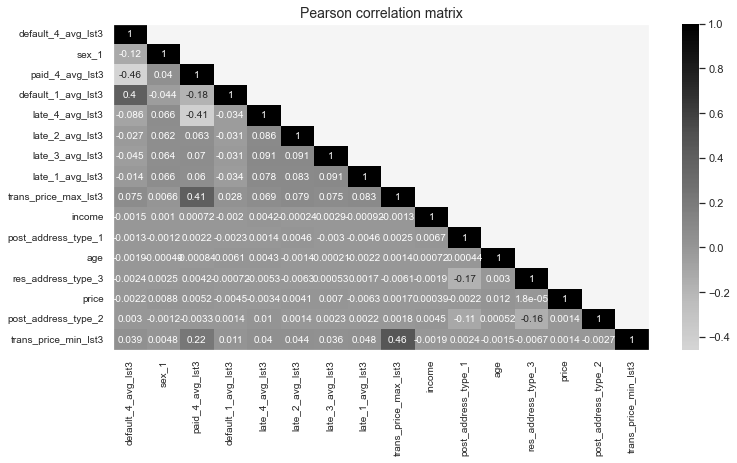

In [56]:
corr_plot(train_data, features_corr_filt, method='pearson')

- Test sample

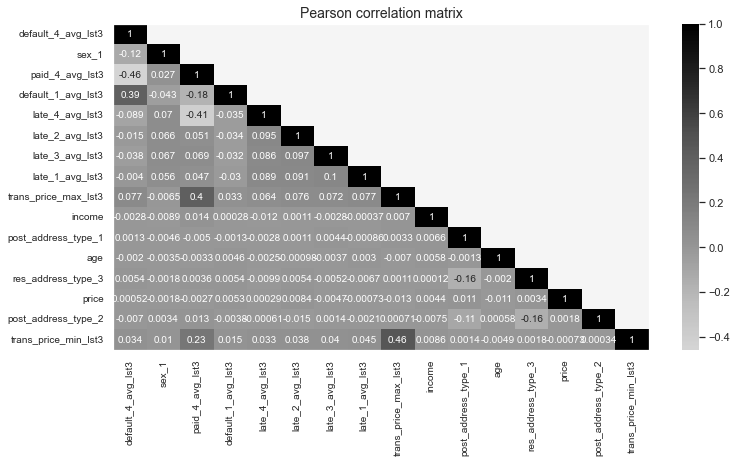

In [57]:
corr_plot(test_data, features_corr_filt, method='pearson')

### Model building

**Logistic regression** from Weight of Evidence-transformed variables

In [58]:
%run -i py/06_stepwise.py

- Stepwise variable selection for the model

In [59]:
features_stepwise = stepwise_selection(train_data[features_woe_corr], train_data['defaulted_fl'])

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(train_data[features_stepwise], train_data['defaulted_fl'])

**Logistic regression** from dummy and raw continuous variables

- Stepwise variable selection for the model

In [60]:
features_stepwise_v2 = stepwise_selection(train_data[features_corr_filt], train_data['defaulted_fl'])

logreg_v2 = LogisticRegression().fit(train_data[features_stepwise_v2], train_data['defaulted_fl'])

#### Naive Bayes

In [61]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB().fit(train_data[features_corr_filt], train_data['defaulted_fl'])

Standardize all features to a common scale in order for the algorithms to give equal weights in distance calculations

In [62]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_data[features_corr_filt])

train_data = train_data.join(pd.DataFrame(scaler.transform(train_data[features_corr_filt]), index=train_data.index, columns=['Scaled_'+f for f in features_corr_filt]))
test_data = test_data.join(pd.DataFrame(scaler.transform(test_data[features_corr_filt]), index=test_data.index, columns=['Scaled_'+f for f in features_corr_filt]))

Using cross validation with weighted F1-scoring to find the best hyperparameters

In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

def weighted_f1_scorer(model, X, y):
    
    scores = [f1_score(y,
                       model.predict_proba(X)[:,1] >= t,
                       average='weighted') for t in np.arange(0,1.05,0.05)]
    
    threshold = np.arange(0,1.05,0.05)[np.argmax(scores)]
    
    f = f1_score(y, np.where(model.predict_proba(X)[:,1] >= threshold, 1, 0), average='weighted')

    return f

cv = KFold(n_splits=3, random_state=523, shuffle=True)

#### Decision Tree

In [64]:
from sklearn.tree import DecisionTreeClassifier

params = {'criterion': ['gini', 'entropy'], 'max_depth': [2,3,4], 'min_samples_leaf': [int(train_data.shape[0]*0.05)]}

dtree_cv = GridSearchCV(DecisionTreeClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[features_corr_filt], train_data['defaulted_fl'])

dtree_cv.best_params_

{'criterion': 'gini', 'max_depth': 2, 'min_samples_leaf': 4216}

#### Random Forest

In [65]:
from sklearn.ensemble import RandomForestClassifier

params = {'n_estimators': [50,60,70], 'criterion': ['gini','entropy'],
          'max_depth': [2,3,4],'min_samples_leaf': [int(train_data.shape[0]*0.05)]}

rf_cv = GridSearchCV(RandomForestClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[features_corr_filt], train_data['defaulted_fl'])

rf_cv.best_params_

{'criterion': 'entropy',
 'max_depth': 3,
 'min_samples_leaf': 4216,
 'n_estimators': 50}

#### Gradient Boosting Tree

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

params = {'learning_rate': [0.1, 0.15, 0.20], 
              'n_estimators': [40,50,60], 'max_depth': [2,3,4],
              'min_samples_leaf': [int(train_data.shape[0]*0.05)]}

gbt_cv = GridSearchCV(GradientBoostingClassifier(),
                        param_grid=params,
                        cv=cv,
                        scoring=weighted_f1_scorer).fit(train_data[features_corr_filt], train_data['defaulted_fl'])

gbt_cv.best_params_

{'learning_rate': 0.15,
 'max_depth': 3,
 'min_samples_leaf': 4216,
 'n_estimators': 40}

### Model performances

Because of the inbalanced dataset weighted F1-score will be used for model evaluation

Model with the highest weighted F1-score on the test sample will be selected as final model.

In [67]:
def weighted_f1_perf(model, train, test, features, target):
    
    scores = [f1_score(train[target], model.predict_proba(train[features])[:,1] >= t,
                       average='weighted') for t in np.arange(0,1.05,0.05)]
    
    threshold = np.arange(0,1.05,0.05)[np.argmax(scores)]
    
    f_train = f1_score(train[target], np.where(model.predict_proba(train[features])[:,1] >= threshold, 1, 0), average='weighted')
    f_test = f1_score(test[target], np.where(model.predict_proba(test[features])[:,1] >= threshold, 1, 0), average='weighted')

    return round(threshold,2), f_train, f_test

In [68]:
performances = {}

performances['LogisticRegression'] = weighted_f1_perf(logreg, train_data, test_data, features_stepwise, 'defaulted_fl')
performances['LogisticRegressionV2'] = weighted_f1_perf(logreg_v2, train_data, test_data, features_stepwise_v2, 'defaulted_fl')

performances['NaiveBayes'] = weighted_f1_perf(naive, train_data, test_data, features_corr_filt, 'defaulted_fl')

performances['DecisionTree'] = weighted_f1_perf(dtree_cv, train_data, test_data, features_corr_filt, 'defaulted_fl')
performances['RandomForest'] = weighted_f1_perf(rf_cv, train_data, test_data, features_corr_filt, 'defaulted_fl')
performances['GradientBoostingTree'] = weighted_f1_perf(gbt_cv, train_data, test_data, features_corr_filt, 'defaulted_fl')

In [69]:
import operator

perf_on_train = {}
perf_on_test = {}

for model in performances.keys():
    
    perf_on_train[model] = performances[model][1]
    perf_on_test[model] = performances[model][2]

perf_on_train = dict(sorted(perf_on_train.items(), key=operator.itemgetter(1),reverse=True))
perf_on_test = dict(sorted(perf_on_test.items(), key=operator.itemgetter(1),reverse=True))

Visualize Weighted F1-score values of algorithms in both samples

- Train sample

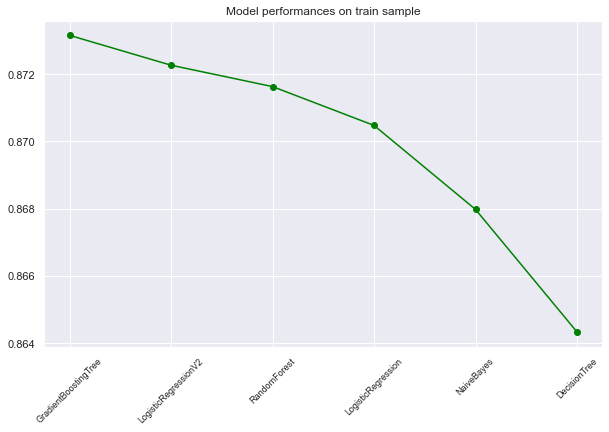

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(list(perf_on_train.keys()), perf_on_train.values(), color='green', marker='o', ls=None)
labels = ax.get_xticklabels()
plt.setp(labels,rotation=45, horizontalalignment='center',fontsize=9)
plt.title('Model performances on train sample')
plt.show()

- Test sample

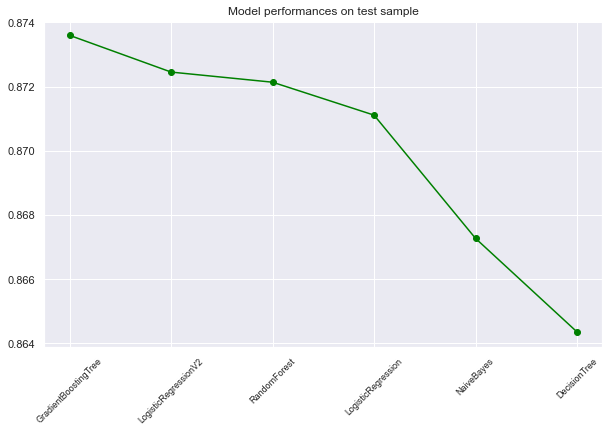

In [71]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(list(perf_on_test.keys()), perf_on_test.values(), color='green', marker='o', ls=None)
labels = ax.get_xticklabels()
plt.setp(labels,rotation=45, horizontalalignment='center',fontsize=9)
plt.title('Model performances on test sample')
plt.show()

Based on the model performances on test sample, Gradient Boosting Tree model is selected for final model.

Binary classification report for the final model is below:

In [72]:
from sklearn.metrics import classification_report

print(classification_report(test_data['defaulted_fl'], 
                      np.where(gbt_cv.predict_proba(test_data[features_corr_filt])[:,1]
                               >= performances['GradientBoostingTree'][0], 1, 0)))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95     32821
           1       0.33      0.11      0.17      3322

    accuracy                           0.90     36143
   macro avg       0.62      0.54      0.56     36143
weighted avg       0.86      0.90      0.87     36143

